# Deep Learning
### Week 4: Neural network training

## Contents

[1. Introduction](#introduction)

[2. Optimisers](#optimisers)

[3. Weight regularisation and early stopping](#regularisation)

[4. TensorFlow regularisers, Dropout layers and callbacks (\*)](#tf_regularisation)

[5. Weight initialisation](#weight_init)

[References](#references)

<a class="anchor" id="introduction"></a>
## Introduction

In the last week of the module we studied the error backpropagation algorithm, which is the central algorithm used to compute gradients in the training of neural networks. We also saw how to use the automatic differentiation tools in TensorFlow, as well as introduced data pipelines with the tf.data module. Finally, we saw two commonly used techniques used in deep learning models, which are dropout and batch normalization. 

In this week of the course, we will continue to look at neural network training, with a focus on the practical techniques that are used to successfully train these models. We will study various optimisation algorithms that are used, as well as regularisation techniques and weight initialisation strategies. 

We will also learn how to implement all of these techniques in TensorFlow, as well as making use of Callback objects.

<a class="anchor" id="optimisers"></a>
## Optimisers

Recall the two main steps to training neural networks:

1. Computation of the (stochastic) gradient of the loss function with respect to the model parameters
2. Use of the computed gradient to update the parameters

Now that we have seen how gradients of the loss with respect to the parameters can be efficiently computed using the backpropagation algorithm (step 1), we will take a look at several popular gradient-based optimisation algorithms used in deep learning (step 2).

In [1]:
import tensorflow as tf

2024-02-02 12:29:05.314610: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Stochastic gradient descent
We have already seen how stochastic gradient descent (SGD, [Robbins & Monro 1951](#Robbins51)) can be applied to optimise neural network parameters. 

Recall that SGD computes stochastic gradients by computing the loss on a minibatch of samples:

$$
L(\theta_t; \mathcal{D}_m) = \frac{1}{M} \sum_{x_i, y_i\in\mathcal{D}_m} l(y_i, f_{\theta_t}(x_i)),
$$

where $\mathcal{D}_m$ is a randomly sampled minibatch of training data points, $M = |\mathcal{D}_m|$ is the size of the minibatch (typically much smaller than $|\mathcal{D}_{train}|$). We then use the gradient $\nabla\tilde{L}(\theta_t)$ to update the parameters according to the SGD update rule

$$
\theta_{t+1} = \theta_{t} - \eta \nabla_{\theta_t} L(\theta_t; \mathcal{D}_m),\qquad t\in\mathbb{N}_0.
$$

In TensorFlow, an SGD optimizer object can be instantiated from the `tf.keras.optimizers` module. 

Optimiser objects like this one can be passed directly into the `optimizer` keyword argument in `model.compile` instead of the string reference `'sgd'`. This is useful, for example if you want to change the learning rate default.

In [5]:
# Create an SGD optimiser

sgd = tf.keras.optimizers.SGD()

#DEFAULT LEARNING RATE IS 0.01

print(sgd.lr)  # Default learning rate

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.01>


In [9]:
# Create a new sgd optimiser and change the learning rate 

sgd = tf.keras.optimizers.SGD(learning_rate=0.005)

print(sgd.lr)

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.005>


Stochastic gradient descent reduces redudancy in the gradient computation, and is faster than full (batch) gradient descent. However some challenges remain: 

* Convergence can still be very slow with SGD
* Setting the learning correctly can be difficult, involving trial and error
* Different weights might operate on different scales, and require different rates of learning

Several optimisation algorithms have been proposed to help treat these problems.

#### Momentum

One common tweak to accelerate the slow convergence of SGD is to add momentum ([Qian 1999](#Qian99)):

$$
\begin{align}
\mathbf{g}_t :=&~ \nabla_\theta L(\theta_t; \mathcal{D}_m),\\
\mathbf{v}_{t+1} =&~ \beta \mathbf{v}_t + \eta\mathbf{g}_t\\
\theta_{t+1} =&~ \theta_t - \mathbf{v}_{t+1},
\end{align}
$$

where $\beta\ge0$ is the momentum term, and as before, $\eta>0$ is the learning rate. When $\beta=0$ then we recover plain SGD, but with $\beta>0$ (a typical value is around 0.9), this gives the gradient a short term memory which often accelerates convergence.

Momentum can be added when created an SDG optimizer using the `momentum` keyword argument. The default value is `0.0` (plain SGD).

In [10]:
# Create an SGD optimiser with momentum

sgd_with_momentum = tf.keras.optimizers.SGD(momentum=0.9)

#lr is still 0.01
#check documentation for exact formulation, since it is slightly different to that of MFOML
print(sgd_with_momentum.lr)
print(sgd_with_momentum.momentum)

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.01>
0.9


#### Nesterov momentum

A common variant of momentum is to use Nesterov momentum ([Nesterov 1983](#Nesterov83)), which computes the gradient correction after the accumulated gradient, instead of before:

$$
\begin{align}
\mathbf{g}_t &= \nabla_\theta L(\theta_t - \beta\mathbf{v}_t; \mathcal{D}_m),\\
\mathbf{v}_{t+1} &= \beta \mathbf{v}_t + \eta\mathbf{g}_t\\
\theta_{t+1} &= \theta_t - \mathbf{v}_{t+1},
\end{align}
$$

The accumulated gradient approximates the next value of the parameters, and so by evaluating the gradient $\nabla_\theta\tilde{L}(\theta_t - \beta\mathbf{v}_t )$, this gives the optimiser a sense of 'look-ahead'.

<img src="figures/nesterov_momentum.png" alt="Nesterov momentum" style="width: 550px;"/>

Nesterov momentum can be added to an SGD optimizer using the `nesterov` keyword argument. The default value is `False`.

In [11]:
# Create an SGD optimiser with momentum

#looks ahead to what the gradient will be where it is going so it can start to act in advance
sgd_with_momentum = tf.keras.optimizers.SGD(momentum=0.9, nesterov=True)

print(sgd_with_momentum.momentum)
print(sgd_with_momentum.nesterov)

0.9
True


#### Adagrad

The Adagrad optimiser ([Duchi et al 2011](#Duchi11)) adapts the learning rate for each parameter, to account for different weights learning on different scales. Parameters that receive a gradient less frequently have larger updates, making Adagrad well suited to sparse data, where most of the features are zero in the data. It is used, for example, in [Pennington et al 2014](#Pennington14) to train GloVe word embedding vectors.

The update rule is

$$
\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{G_t + \epsilon}} \odot \nabla_\theta L(\theta_t; \mathcal{D}_m),
$$

where $G_t\in\mathbb{R}^{p\times p}$ is a diagonal matrix where the diagonal element $(G_t)_{ii}$ is the sum of squares of gradients with respect to $\theta_i$ up to time step $t$. In the above, the division and square root operations are performed element-wise, and $\odot$ is the Hadamard product.

Note that the resulting learning rates per parameter are monotonically decreasing, and eventually the algorithm effectively stops learning.

The Adagrad optimiser can be instantiated as follows:

In [12]:
# Create an Adagrad optimiser


#VERY SUITED TO SPARSE DATA 


#epsilon stops division by 0
adagrad = tf.keras.optimizers.Adagrad(
    learning_rate=0.001, epsilon=1e-07,
)

In the above, all keyword arguments shown are the default settings.

#### RMSprop

RMSprop is an unpublished optimisation method that aims to resolve the vanishing learning rates of Adagrad (it appeared in Geoff Hinton's Coursera course [in lecture 6e](http://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf)). It uses a decaying average of past squared gradients. 

The update rule is

$$
\begin{align}
\mathbb{E}[\mathbf{g}^2]_t &= \rho \mathbb{E}[\mathbf{g}^2]_{t-1} + (1 - \rho)(\nabla_\theta L(\theta_t; \mathcal{D}_m))^2\\
\theta_{t+1} &= \theta_t - \frac{\eta}{\sqrt{\mathbb{E}[\mathbf{g}^2]_t + \epsilon}} \odot \nabla_\theta L(\theta_t; \mathcal{D}_m)
\end{align}
$$

As before, the division and square root are performed element-wise, and $\odot$ is the Hadamard product. The $\rho$ term is typically set similar to momentum, around 0.9.

The RMSprop can be instantiated as follows:

In [13]:
# Create an RMSprop optimiser

rmsprop = tf.keras.optimizers.RMSprop(
    learning_rate=0.001, rho=0.9, epsilon=1e-07
)

Again the above are the default settings. Momentum can also be added to the `RMSprop` optimiser with the `momentum` keyword argument:

In [14]:
# Create an RMSprop optimiser with momentum

rmsprop_with_momentum = tf.keras.optimizers.RMSprop(momentum=0.9)

The RMSprop optimiser is also the default optimiser that is chosen if `model.compile` is called without the `optimizer` keyword argument.

#### Adam

The Adam optimiser ([Kingma 2015](#Kingma15)) is a popular optimisation algorithm, that also computes adaptive learning rates per parameter. It estimates first and second moments of the gradients, and the name stands for <ins>Ada</ins>ptive <ins>m</ins>oment estimation.

The update rule is

$$
\begin{align}
\mathbb{E}[\mathbf{g}]_t &= \beta_1\mathbb{E}[\mathbf{g}]_{t-1} + (1 - \beta_1) \nabla_\theta L(\theta_t; \mathcal{D}_m),\\
\mathbb{E}[\mathbf{g}^2]_t &= \beta_2\mathbb{E}[\mathbf{g}^2]_{t-1} + (1 - \beta_2) (\nabla_\theta L(\theta_t; \mathcal{D}_m))^2,\\
\mathbf{m}_t &= \mathbb{E}[\mathbf{g}]_t / (1 - \beta_1),\\
\mathbf{v}_t &= \mathbb{E}[\mathbf{g}^2]_t / (1 - \beta_2),\\
\theta_{t+1} &= \theta_t - \frac{\eta}{\sqrt{\mathbf{v}_t + \epsilon}}\odot \mathbf{m}_t
\end{align}
$$

The $\mathbf{m}_t$ and $\mathbf{v}_t$ terms correct for an initial bias towards zero. Typical values are $\beta_1 \approx 0.9$, $\beta_2 \approx 0.999$ and $\epsilon \approx 10^{-7}$.

The Adam optimiser can be instantiated as follows:

In [15]:
# Create an Adam optimiser

adam = tf.keras.optimizers.Adam()

#the default parameter settings 
print(adam.lr)
print(adam.beta_1)
print(adam.beta_2)
print(adam.epsilon)

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>
0.9
0.999
1e-07


The above is a non-exhaustive list of optimisers that have been developed and are actively used in deep learning research and practice. See [here](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) for a complete of the optimisers that are available to use in Tensorflow.

The code below will create a demonstration optimization run using one of each of the optimizers described above for the [Beale function](http://benchmarkfcns.xyz/benchmarkfcns/bealefcn.html), a common test function used to evaluate optimization algorithms.

In [ ]:
def beale(x, y):
    return (1.5 - x + x * y)**2 + (2.25 - x + x * (y**2))**2 + (2.625 - x + x * (y**3))**2

def grad_beale(x, y):
    ddx = 2*(1.5 - x + x * y)*(y - 1) + 2*(2.25 - x + x * (y**2))*((y**2) - 1) + 2*(2.625 - x + x * (y**3))*((y**3)-1)
    ddy = 2*(1.5 - x + x * y)*(x) + 2*(2.25 - x + x * (y**2))*(2*y*x) + 2*(2.625 - x + x * (y**3))*(3*(y**2)*x)
    return [ddx, ddy]

In this case the gradient is easy enough to calculate by hand as above. Later in this week you will learn how to use the [automatic differentiation](#autodiff) tools in TensorFlow to compute the gradient of any differentiable function for you.

The cell below will run the optimization routine for 100 iterations for each optimizer, and plot the trajectories over the contour plot of the Beale function. Feel free to interrupt the cell execution and restart it to try a different random initial condition. You can also try changing the learning rates and other parameters to see the effect on convergence.

In [ ]:
from IPython import display
import matplotlib.pyplot as plt
import numpy as np

x_init = tf.random.normal(())
y_init = tf.random.normal(())

test_fn = beale
grad_fn = grad_beale

X, Y = np.meshgrid(np.linspace(-4, 4, 100), np.linspace(-4, 4, 100))
Z = test_fn(X, Y)
levels = np.exp(np.linspace(0, 10, 25)) - 1
plt.figure(figsize=(13, 8))
plt.contour(X, Y, Z, levels, alpha=0.6, cmap='viridis')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(x_init.numpy(), y_init.numpy())
plt.scatter(3, 0.5, marker='*', label='Optimum')
optimizers_config = [
    {"name": "SGD", "kwargs": {"learning_rate": 0.01}, "label": "SGD"},
    {"name": "SGD", "kwargs": {"learning_rate": 0.001, "momentum": 0.9, "nesterov": True}, "label": "SGD-NAG"},
    {"name": "Adam", "kwargs": {"learning_rate": 0.1}, "label": "Adam"},
    {"name": "Adagrad", "kwargs": {"learning_rate": 0.1}, "label": "Adagrad"},
    {"name": "RMSprop", "kwargs": {"learning_rate": 0.05}, "label": "RMSprop"}
]
optimizers, states, plot_data = [], [], []
for optimizer in optimizers_config:
    optimizers.append(getattr(tf.keras.optimizers, optimizer['name'])(**optimizer['kwargs']))
    states.append((tf.Variable(x_init, name='x_{}'.format(optimizer['name'])), 
                   tf.Variable(y_init, name='y_{}'.format(optimizer['name']))))
    opt_plot, = plt.plot([x_init.numpy()], [y_init.numpy()], label=optimizer['label'])
    plot_data.append(opt_plot)
plt.title("Test optimization run with {} optimizers. Initial conditions x: {:.4f}, y: {:.4f}".format(
    len(optimizers), x_init.numpy(), y_init.numpy()), fontsize=14)

num_iterations = 100
for i in range(num_iterations):
    try:
        for optimizer, state, data in zip(optimizers, states, plot_data):
            grads = grad_fn(state[0], state[1])
            optimizer.apply_gradients(zip(grads, state))
            data.set_xdata(np.append(data.get_xdata(), state[0].numpy()))
            data.set_ydata(np.append(data.get_ydata(), state[1].numpy()))
        plt.text(0.01, 0.01, 'Iteration {}'.format(i+1), horizontalalignment='left', 
                 verticalalignment='bottom', transform = plt.gca().transAxes, 
                 fontsize=12, bbox=dict(facecolor='white', alpha=1.))
        plt.legend(fontsize=12)
        display.display(plt.gcf())
        display.clear_output(wait=True)
    except KeyboardInterrupt:
        break

There is no single answer for which optimiser is best to use, as it very often depends on the data and the model. Optimisers with adaptive learning rates tend to convergence faster in most situations, and are more frequently chosen than plain SGD in most situations. However, it is interesting to note that SGD has been shown to generalise better ([Hardt et al 2015](#Hardt15)), and techniques such as switching from Adam to SGD during training have been proposed ([Keskar & Socher 2017](#Keskar17)). Further methods include annealed learning rates, cyclic learning rates ([Smith 2015](#Smith15)) and decaying momentum ([Chen & Kyrillidis 2019](#Chen19)). Many advances have been made in recent years, and neural network optimisation is still very much an active research area.

*Exercise.* Change the Beale function above for a different [test function](https://en.wikipedia.org/wiki/Test_functions_for_optimization) in the above code.

<a class="anchor" id="regularisation"></a>
## Weight regularisation and early stopping

Deep learning models are typically very over-parameterised, often with millions of parameters over many layers in the model. They are universal approximators (see e.g. [Cybenko](#Cybenko89) for the large width case, or [Lu et al](#Lu17) for the large depth case), and so overfitting can be a problem. When training neural networks, it is important to regularise them to prevent overfitting. As written above, there are several forms of regularisation, but in this section we will look at three in particular: weight regularisation, dropout and early stopping.

#### $\mathcal{l}^2$ and $\mathcal{l}^1$ regularisation
Recall that for a linear model of the form

$$
f(\mathbf{x}) = \sum_j w_j \phi_j(\mathbf{x}),
$$

a typical regularisation is to add a sum of squares penalty term to the loss term to discourage the weights $w_j$ from growing too large. In this case, the regularised loss takes the form


$$
L(\mathbf{w}, \alpha) = L_0(\mathbf{w}) + \alpha_2 \sum_i w_i^2,
$$

where $L_0$ is the unconstrained loss function, and $\alpha_2$ is a regularisation hyperparameter. This is $\mathcal{l}^2$ regularisation.

This form of regularisation is often referred to as **weight decay**, although the two terms are technically not the same. Weight decay ([Hanson & Pratt](#Hanson88)) is defined as a modification to the update rule, rather than to the loss function itself:

$$
\mathbf{\theta}_{t+1} \leftarrow (1 - \lambda)\theta_t - \eta g_t,
$$

where $\theta\in\mathbb{R}^p$ is the model parameters, $\lambda$, $\eta$ are hyperparameters, and $g_t$ is the $t$-th batch update. In the case of stochastic gradient descent, the update $g_t = \nabla_\theta L(\theta_t; \mathcal{D}_m)$ and the two formulations are equivalent. However, this is not the case for all gradient-based optimisers commonly used in deep learning.

An alternative weight regularisation is $\mathcal{l}^1$ regularisation, in which the sum of absolute values of the weights are added to the loss term:

$$
L(\mathbf{w}, \alpha) = L_0(\mathbf{w}) + \alpha_1 \sum_i |w_i|.
$$

This form of regularisation encourages sparsity in the weights. Both $\mathcal{l}^1$ and $\mathcal{l}^2$ regularisation discourage the weights from growing too large, which restricts the capacity of the network.

It is also possible to add a weighted combination of both $\mathcal{l}^2$ and $\mathcal{l}^1$ regularisation to the loss function.

#### Early stopping

You might have found in the last week that it is difficult to set a good number of epochs to train for ahead of time. In the simple MNIST example training is quick so it is not a problem to experiment, but in many cases training could take hours or days (or even longer!) and so this is not an option. 

Recall that deep learning models are usually vastly overparameterised, and have the capacity to drastically overfit. A simple but effective method is to simply stop the training before the model starts to overfit. The picture is similar to the balance between capacity and generalisation:

<img src="figures/early_stopping.png" alt="Early stopping" style="width: 500px;"/>
<center>Prediction error vs number of training epochs</center>

With early stopping, the aim is to stop the training when the validation error is at a minimum. This means that the model needs to be regularly evaluated on a held-out validation set (that is not used for training), and the optimisation routine is terminated when the validation error starts to rise. Validation is normally performed once per epoch in the training run.

In practice, the validation error measurements will be noisy, and so it is not a reliable measure to simply detect when the validation error increases and immediately stop the training. What is usually done is to periodically save model checkpoints (say once per epoch), and set a **patience** threshold, to specify a maximum number of validation runs that are allowed where the validation error does not improve upon the best score so far. If this patience threshold is reached, the training is terminated.

The early stopping algorithm is outlined in pseudocode below.

Early stopping inputs: `val_metric`, `max_patience`

-------
>```
>best_valid_loss = np.inf
>patience = 0
>
>for epoch in range(max_epochs):
>    epoch_train_loss = train_model(train_data, train_loss)
>    epoch_valid_loss = validate_model(valid_data, val_metric)
>    if epoch_valid_loss < best_valid_loss:
>        best_valid_loss = epoch_valid_loss
>        patience = 0
>    else:
>        patience += 1
>        
>    save_model(epoch)
>    
>    if patience >= max_patience:
>        break  # terminate training
>```

-------

It is also possible to validate the model using a measure that is different to the loss function used for training the model. Therefore `val_metric` is also an input to the early stopping algorithm above.

Of course, all of the regularisation techniques mentioned here (and more) can be used together in deep learning models (and they often are).

<a class="anchor" id="tf_regularisation"></a>
## TensorFlow regularisers, Dropout layers and callbacks

In this section we will build on what we have covered already with the `Sequential` API, and include weight regularisers, `Dropout` layers, and introduce callback objects - these are very useful objects for dynamically performing operations during the training run. An example is the `EarlyStopping` callback.

In [ ]:
import tensorflow as tf

For this tutorial we will use the diabetes dataset from `sklearn`.

In [44]:
# Load the diabetes dataset
from sklearn.datasets import load_diabetes
diabetes_data = load_diabetes()

In [45]:
# Print dataset description

print(diabetes_data["DESCR"])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

In [46]:
# Get the input and target data

print(diabetes_data.keys())
data = diabetes_data["data"]
target = diabetes_data["target"]


dict_keys(['data', 'target', 'frame', 'DESCR', 'feature_names', 'data_filename', 'target_filename', 'data_module'])


In [47]:
# Normalise the target data (this will make clearer training curves)

target = (target - target.mean())/target.std()

In [48]:
# Partition the data into training and validation sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data,target, test_size=0.2)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(353, 10)
(89, 10)
(353,)
(89,)


In [49]:
# Load the data into training and validation Dataset objects

train_dataset = tf.data.Dataset.from_tensor_slices((X_train,y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_test,y_test))

#shuffle buffer of all data
train_dataset = train_dataset.shuffle(353)
#batch it
train_dataset =train_dataset.batch(128)
val_dataset = val_dataset.batch(89)

#PREFETCHING overlaps loading and processing of data with the execution using the model
#so while model is computing output on one batch, in parallel we are preparing next batch for use

#makes more of a difference in larger datasets
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

In [60]:
# Build the MLP model
from keras.models import Sequential
from keras.layers import Dense

#could equally do X_train.shape[1:] and not do the bracket around it
model = Sequential([
    Dense(256, activation = "relu", input_shape = (X_train.shape[-1],)),
    Dense(256, activation = "relu"),
    Dense(256, activation = "relu"),
    #output layer
    Dense(1)
]
)


In [61]:
# Print the model summary
#we can do this since we told it the input shape, so it can initialise the weights
print(model.summary())


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 256)               2816      
                                                                 
 dense_12 (Dense)            (None, 256)               65792     
                                                                 
 dense_13 (Dense)            (None, 256)               65792     
                                                                 
 dense_14 (Dense)            (None, 1)                 257       
                                                                 
Total params: 134657 (526.00 KB)
Trainable params: 134657 (526.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [62]:
# Compile the model

model.compile(optimizer = "adam", loss = "mse")

In [63]:
# Train the model, including validation

history = model.fit(train_dataset, epochs = 100,validation_data= val_dataset,verbose = False)

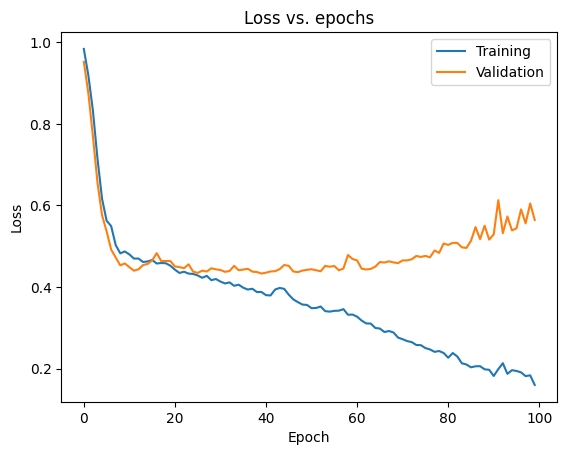

In [64]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
#history object also contains validation loss now since we told it to
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()


### VERY CLEAR OVERFITTING HERE, do regularisation ###

#### Regularise the model

Both $\mathcal{l}^2$ and $\mathcal{l}^1$ regularisation can easily be included using the `kernel_regularizer` and `bias_regularizer` keyword arguments in the `Dense` layer.

Dropout can also be easily included as an additional layer of our model.

In [67]:
# Redefine the model using l2 regularisation and dropout

from keras.layers import Dropout
from keras import regularizers

l2_coef = 1e-5
rate = 0.5

def get_regulariszed_model():
    model = Sequential([
        #regularization
        Dense(256, kernel_regularizer= regularizers.l2(l2_coef), activation = "relu", input_shape = (X_train.shape[-1],)),
        Dropout(rate = rate),
        Dense(256, kernel_regularizer= regularizers.l2(l2_coef),activation = "relu"),
        Dropout(rate = rate),
        Dense(256, kernel_regularizer= regularizers.l2(l2_coef),activation = "relu"),
        Dropout(rate = rate),
        #output layer
        Dense(1)
])
    return model

model = get_regulariszed_model()

In [68]:
# Compile the model

model.compile(optimizer = "adam", loss = "mse")

In [69]:
# Train the model, including validation

history = model.fit(train_dataset, epochs = 100,validation_data= val_dataset,verbose = False)

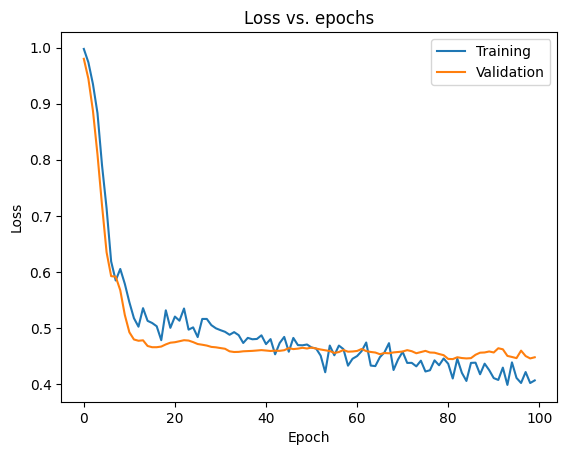

In [70]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

### GENERALISATION GAP HAS CLOSED - DIFFERENCE BETWEEN SEPARATE VALIDATION SET AND TRAINING, like MFOML

The $\mathcal{l}^2$ regularisation and dropout have helped to reduce the overfitting of the model. 


#### Callbacks
We can go one step further and introduce early stopping as well, and save the model weights at the best validation score. We can do this with callbacks.

In [ ]:
# Create a new model



In [ ]:
# Compile the model



The `EarlyStopping` callback is a built-in callback in the `tf.keras.callbacks` module. You can see a complete list of built-in callbacks [here](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks).

In [ ]:
# Create an EarlyStopping callback



In [ ]:
# Train the model, including validation



In [ ]:
# Plot the training and validation metrics

import numpy as np

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(np.arange(len(history.history['loss'])))
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

#### Custom callbacks

It is also possible (and often useful) to create custom callbacks to perform certain actions depending on the training progress. We will look at building a custom callback to save the model weights, dependent on the performance of a specified validation metric.

Note that the `tf.keras.callbacks` module has the built-in callback `ModelCheckpoint`, which automatically handles model saving for Keras models. We will look at a slightly lower-level method for model saving, using the `tf.train` module.

In [ ]:
# Create a custom callback for saving the model weights



In [ ]:
# Create a new model



In [ ]:
# Compile the model



In [ ]:
# Train the model, including validation



In [ ]:
# Inspect the saved checkpoints



In [ ]:
# Plot the training and validation metrics

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_mae'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(np.arange(len(history.history['loss'])))
plt.legend(['Training', 'Val loss', 'Val MAE'], loc='upper right')
plt.show()

In [ ]:
# Re-initialise the model



In [ ]:
# Restore the best model weights



In [ ]:
# Clean up



<a class="anchor" id="weight_init"></a>
## Weight initialisation

In practice, a good initialisation strategy for the weights of our network is often necessary to enable the network to train efficiently. With a bad initialisation, the network might take a long time to train, or might not be able to train at all. To understand why problems might arise, we need to look back to the backpropagation algorithm.

We first recall the main equations from the backpropagation algorithm for an MLP network with $L$ hidden layers. The MLP is defined with the transformations:


$$
\begin{align}
\mathbf{h}^{(0)} &:= \mathbf{x},\\
\mathbf{h}^{(k)} &= \sigma\left( \mathbf{W}^{(k-1)}\mathbf{h}^{(k-1)} + \mathbf{b}^{(k-1)} \right),\qquad k=1,\ldots, L,\\
\hat{\mathbf{y}} &= \sigma_{out}\left( \mathbf{w}^{(L)}\mathbf{h}^{(L)} + b^{(L)} \right),
\end{align}
$$

where $\mathbf{W}^{(k)}\in\mathbb{R}^{n_{k+1}\times n_k}$, $\mathbf{b}^{(k)}\in\mathbb{R}^{n_{k+1}}$, $\mathbf{h}^{(k)}\in\mathbb{R}^{n_k}$, $\hat{\mathbf{y}}\in Y$, $\sigma, \sigma_{out}:\mathbb{R}\mapsto\mathbb{R}$ are activation functions that are applied element-wise, $n_0 := D$, and $n_k$ is the number of units in the $k$-th hidden layer. 

Also recall that we define the **pre-activations**

$$
\mathbf{a}^{(k)} = \mathbf{W}^{(k-1)}\mathbf{h}^{(k-1)} + \mathbf{b}^{(k-1)} 
$$

and **post-activations**

$$
\mathbf{h}^{(k)} = \sigma(\mathbf{a}^{(k)}).
$$

<img src="figures/forward.png" alt="Forward pass" style="width: 800px;"/>
<center>Pre-activations, post-activations, weights and biases in the forward pass</center>

Define the **error** $\delta^{(k)}_p := \frac{\partial L_i}{\partial a^{(k)}_p}$, where $L_i$ is the loss for example $i$. Then we have

$$
\begin{align}
\frac{\partial L_i}{\partial w^{(k)}_{pq}} &= \delta^{(k+1)}_p h^{(k)}_q \\
\frac{\partial L_i}{\partial b^{(k)}_{p}} &= \delta^{(k+1)}_p. 
\end{align}
$$


We can summarise the backpropagation algorithm as the forward and backward pass.

<table>
    <tr>
        <td>
\begin{eqnarray}
&\text{Forward pass:} \\
&\mathbf{a}^{(k)}  = \mathbf{W}^{(k-1)}\mathbf{h}^{(k-1)} + \mathbf{b}^{(k-1)} \\
           & \mathbf{h}^{(k)}  = \sigma(\mathbf{a}^{(k)})  \\
\end{eqnarray}
        </td>
        <td>
\begin{eqnarray}
            &\text{Backward pass:} \\
&\mathbf{\delta}^{(k)} = \mathbf{\sigma}'(\mathbf{a}^{(k)})(\mathbf{W}^{(k)})^T \mathbf{\delta}^{(k+1)} \\
& \sigma'(\mathbf{a}^{(k)}) = \text{diag}([\sigma'(a_p^{(k)})]_{p=1}^{n_k})
\end{eqnarray}
        </td>
    </tr>
</table>

#### Xavier / Glorot initialisation

We will look at a common initialisation strategy often referred to as Xavier or Glorot initialisation, after the lead author of the paper that first proposed it ([Glorot 2010](#Glorot10)). The idea behind this initialisation strategy is to choose a distribution from which we can sample the initial weight values, in such a way that it ensures a strong signal is able to propagate both forwards and backwards through the network in the backpropagation algorithm.

At a high level, this initialisation strategy consists of choosing a univariate distribution with zero mean that each of the weight parameters can be independently sampled from. As we will see, we will need to control the variance of this weight distribution to ensure good signal flow. The biases do not play an important role, and we initialise all bias terms to zero.

In order to motivate things, we can see the effects of this initialisation scheme in the following figure, taken from the original paper.

<img src="figures/activation_saturation.png" alt="Saturation of activations" style="width: 800px;"/>
<center>Activation values of an MLP with four hidden layers over a training run</center>

In the above figure, mean and standard deviation statistics of activation values were recorded over a training run of a multilayer perceptron with four hidden layers, each of which uses a sigmoid activation function. 

At the start of training, the activations in the last hidden layer quickly go to zero, which is one of the saturation values of the sigmoid function. This saturation of activation values lasts for a long time in the training, suggesting that the gradients that are being computed are very small, and things only start picking up again at around epoch 100. 

The hypothesis made in the paper is that the root of the problem is a bad initial set of parameters, which doesn't allow a strong training signal to be propagated to all the layers of the network. In particular, at the start of training there is a strong signal, or gradient for the parameters in the last hidden layer, but this gradient diminishes very quickly as you go backwards down the layers. 

The figures below show histograms of activation values (left), and gradient values (right). The top and bottom rows show histograms for these values without and with Xavier initialisation respectively. 

The top left figure shows that in the lower layers there is a good spread of activation values. However, as you go deeper into the network these activations start to shrink, because the sigmoid activations are starting to saturate. This can be interpreted as the forward signal being diminished as you go through the layers.

The top right figure shows the reverse for the gradients. The deepest hidden layer has the largest spread of values, but by the time the error has been backpropagated to the first hidden layer, the signal is significantly smaller.

On the bottom row you can see the effect of the Xavier initialisation is to produce a strong signal that propagates well forwards and backwards throughout the layers of the network. In particular, the spread of activation values is roughly the same in all layers.

<table><tr>
<td> <img src="figures/activation_histograms.png" alt="Saturation of activations" style="width: 400px;"/> </td>
<td> <img src="figures/gradient_histograms.png" alt="Saturation of activations" style="width: 400px;"/> </td>
</tr></table>
<center>Histograms of activation and gradient values</center>

The derivation of the Xavier initialisation scheme makes the following assumptions:

* The pre-activation values are in the linear region of the activation function: $\sigma(\mathbf{a}^{(k)}) \approx \mathbf{a}^{(k)}$, $\sigma'(\mathbf{a}^{(k)})\approx I$
* The input features $x_j$ have zero mean and shared variances ($\text{Var}[x_j] = \text{Var}[x]$)

The first of these is a strong assumption, and later work build on the findings in the paper to relax this. The second assumption is trivially satisfied by normalising the data inputs.

We will fix a zero-mean univariate distribution for each layer, and within the layer we will independently sample each of the weight parameters from this distribution.

**The aim of Xavier initialisation is to control the variance of activations within each layer, as well as the variance of the errors.** We want these variances to remain roughly constant throughout all of the layers of the network.

If we first consider the variance of the activations, then from the forward pass equations and the linearity of the activation function, we have

$$
\begin{align}
a_j^{(k)} & = \sum_{i=1}^{n_{k-1}} w_{ji}^{(k-1)} a_i^{(k-1)} + b_j^{(k-1)},
\end{align}
$$

where $a_j^{(0)} = x_j$. With our assumptions on the distributions of the input features and weight parameters, we obtain

$$
\begin{align}
\text{Var}[a_j^{(k)}] &= \text{Var}[x] \prod_{k'=0}^{k-1} n_{k'} \text{Var}[W^{(k')}],\label{variances_forward}\tag{1}
\end{align}
$$
where $\text{Var}[x]$ is the (shared) variance of each of the input features $x_j$, and $\text{Var}[W^{(k')}]$ is the variance of the (univariate) distribution over the weights in layer $k'$.

For the variance of the errors, we have from the backward pass equations

$$
\begin{align}
\mathbf{\delta}^{(k)} &= \mathbf{\sigma}'(\mathbf{a}^{(k)})(\mathbf{W}^{(k)})^T \mathbf{\delta}^{(k+1)},
\end{align}
$$

which gives

$$
\begin{align}
\text{Var}[\delta_j^{(k)}] &= \text{Var}\left[ \frac{\partial L_i}{\partial \mathbf{a}^{(L+1)} } \right] \prod_{k'=k}^{L} n_{k'+1} \text{Var}[W^{(k')}],\label{variances_backward}\tag{2}
\end{align}
$$

where now $\text{Var}\left[ \frac{\partial L_i}{\partial \mathbf{a}^{(L+1)} } \right]$ is the variance of the partial derivative of the per-example loss with respect to an output pre-activation, which is assumed to be approximately equal for each output neuron (which is reasonable for a typical loss function, since each $a_j^{(k)}$ has the same variance from \eqref{variances_forward}).

Remember that we want is for the signal to propagate well through the network in both forward and backward passes, such that the variances of the activations and the variances of the errors remain roughly constant throughout the layers. That is, we want to have $\text{Var}[\mathbf{a}^{(k)}]\approx \text{Var}[\mathbf{a}^{(k')}]$ and also $\text{Var}[\delta^{(k)}]\approx \text{Var}[\delta^{(k')}]$.

From \eqref{variances_forward} and \eqref{variances_backward} we can see that this translates into the conditions

$$
\begin{align}
n_k \text{Var}[W^{(k)}] &= 1 \qquad\forall k\quad\text{(forward pass condition)} \\
n_{k+1} \text{Var}[W^{(k)}] &= 1 \qquad\forall k \quad\text{(backward pass condition)}
\end{align}
$$

Unfortunately, unless subsequent layer widths are the same, we can't satisfy both of these requirements simultaneously. Xavier initialisation makes a compromise between these conditions, and sets the variance of the weight distribution to be the harmonic mean of $1 / n_k$ and $1 / n_{k+1}$:

$$
\boxed{\text{Var}[W^{(k)}] = \frac{2}{n_k + n_{k+1}},\quad k=0, 1,\ldots, L}
$$

An example distribution that is zero mean and has the correct variance would be the uniform distribution with the following limits:

$$
w_{ij}^{(k)} \sim U\left[ - \frac{\sqrt{6}}{\sqrt{n_k + n_{k+1}}}, \frac{\sqrt{6}}{\sqrt{n_k + n_{k+1}}} \right]
$$

#### Orthogonal initialisation

An alternative initialisation scheme is orthogonal initialisation, proposed in [Saxe 2014](#Saxe14). The intuition behind this scheme is quite straightforward: both the forward and backward passes involve multiplication by the weight matrices $\mathbf{W}^{(k)}$ for each $k$:

<table>
    <tr>
        <td>
\begin{eqnarray}
&\text{Forward pass:} \\
&\mathbf{a}^{(k)}  = \mathbf{W}^{(k-1)}\mathbf{h}^{(k-1)} + \mathbf{b}^{(k-1)} \\
           & \mathbf{h}^{(k)}  = \sigma(\mathbf{a}^{(k)})  \\
\end{eqnarray}
        </td>
        <td>
\begin{eqnarray}
            &\text{Backward pass:} \\
&\mathbf{\delta}^{(k)} = \mathbf{\sigma}'(\mathbf{a}^{(k)})(\mathbf{W}^{(k)})^T \mathbf{\delta}^{(k+1)} \\
& \sigma'(\mathbf{a}^{(k)}) = \text{diag}([\sigma'(a_p^{(k)})]_{p=1}^{n_k})
\end{eqnarray}
        </td>
    </tr>
</table>

Rather than choosing a univariate distribution to independently sample weight values from, the authors in this paper suggested to initialise each weight matrix $\mathbf{W}^{(k)}$ to be an (semi-)orthogonal matrix. This prevents the matrix multiplication from growing or shrinking the vector of activations or errors respectively, again encouraging a strong signal to be able to propagate to all layers in both forward and backward passes.

Practically, this can be done by first randomly initialising a matrix $\overline{\mathbf{W}}$, and computing its singular value decomposition

$$
\overline{\mathbf{W}} = U\Sigma V^T.
$$

The matrices U and V in the SVD are orthogonal matrices. With the correct settings for the dimensions of these matrices, the matrix V can then be used to initialise the weights in this layer.

<a class="anchor" id="references"></a>
### References

<a class="anchor" id="Chen19"></a>
* Chen, J. & Kyrillidis, A., (2019), "Decaying Momentum Helps Neural Network Training", arXiv preprint arXiv:1910.04952.
<a class="anchor" id="Cybenko89"></a>
* Cybenko, G. (1989) "Approximations by superpositions of sigmoidal functions", Mathematics of Control, Signals, and Systems, **2** (4), 303–314.
<a class="anchor" id="Duchi11"></a>
* Duchi, J., Hazan, E., & Singer, Y. (2011), "Adaptive Subgradient Methods for Online Learning and Stochastic Optimization", *Journal of Machine Learning Research*, **12**, 2121–2159.
<a class="anchor" id="Glorot10"></a>
* Glorot, X. & Bengio, Y. (2010), "Understanding the difficulty of training deep feedforward neural networks", Proceedings of the International Conference on Artificial Intelligence and Statistics (AISTATS'10).
<a class="anchor" id="Hanson88"></a>
* Hanson, S. J. & Pratt, L. Y. (1988) "Comparing biases for minimal network construction with back-propagation", in *Proceedings of the 1st International Conference on Neural Information Processing Systems*,  177–185.
<a class="anchor" id="Hardt15"></a>
* Hardt, M., Recht, B., & Singer, Y. (2015), "Train faster, generalize better: Stability of stochastic gradient descent", in *Proceedings of the 33rd International Conference on International Conference on Machine Learning*, **48**, 1225-1234.
<a class="anchor" id="Keskar17"></a>
* Keskar, N. S. * Socher, R. (2017), "Improving Generalization Performance by Switching from Adam to SGD", arXiv preprint, abs/1712.07628.
<a class="anchor" id="Kingma15"></a>
* Kingma, D. P. & Ba, J. L. (2015), "Adam: a Method for Stochastic Optimization", International Conference on Learning Representations, 1–13.
<a class="anchor" id="Lu17"></a>
* Lu, Z., Pu, H., Wang, F. Hu, Z., & Wang, L. (2017) "The Expressive Power of Neural Networks: A View from the Width", Advances in Neural Information Processing Systems 30. Curran Associates, Inc., 6231–6239.
<a class="anchor" id="Nesterov83"></a>
* Nesterov, Y. (1983), "A method for unconstrained convex minimization problem with the rate of convergence o(1/k2)", Doklady ANSSSR (translated as Soviet. Math. Docl.), **269**, 543–547.
<a class="anchor" id="Pennington14"></a>
* Pennington, J., Socher, R. & Manning, C. D. (2014), "Glove: Global vectors for word representation", in *Proceedings of Empirical Methods in Natural Language Processing (EMNLP)*.
<a class="anchor" id="Qian99"></a>
* Qian, N. (1999), "On the momentum term in gradient descent learning algorithms", Neural Networks: The Official Journal of the International Neural Network Society, **12** (1), 145–151.
<a class="anchor" id="Robbins51"></a>
* Robbins, H. and Monro, S. (1951), "A stochastic approximation method", *The annals of mathematical statistics*, 400–407.
<a class="anchor" id="Saxe14"></a>
* Saxe, A., McClelland, J. and Ganguli, S. (2014), "Exact solutions to the nonlinear dynamics of learning in deep linear neural networks", 2nd International Conference on Learning Representations, (ICLR) 2014, Banff, AB, Canada, April 14-16, 2014.
<a class="anchor" id="Smith15"></a>
* Smith, L. N. (2015), "Cyclical Learning Rates for Training Neural Networks", arXiv preprint, abs/1506.01186.